In [1]:
import phoebe
from phoebe import u # units
import numpy as np
# Mac users may need to turn multi-processing off
#phoebe.multiprocessing_off() 
logger = phoebe.logger('error')

In [2]:
#Load Previous Bundle
b = phoebe.open('synthetic/after_estimators.bundle')

/Users/bertpablo/Dropbox/phoebe-stuff/workshop_2020_tutorials/devel/lib/python3.9/site-packages/phoebe/parameters/parameters.py:10236: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


/Users/bertpablo/Dropbox/phoebe-stuff/workshop_2020_tutorials/devel/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


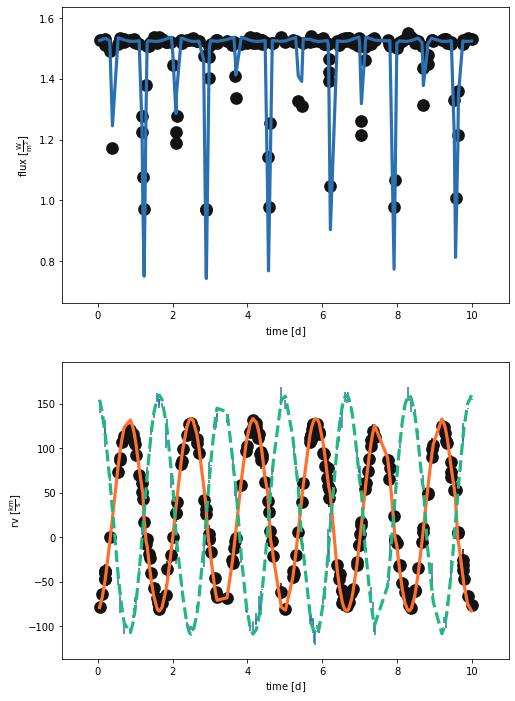

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [3]:
b.plot(show=True)

In [4]:
#Create a new compute parameter set 
b.add_compute(compute='nm_fit')

<ParameterSet: 40 parameters | datasets: rv01, lc01, _default>

In [5]:
# Change fitting options for faster model computation
b.set_value('irrad_method', compute='nm_fit', value='none')
b.set_value_all('rv_method', compute='nm_fit', value='dynamical')
b.set_value_all('distortion_method', compute='nm_fit', value='sphere')


In [6]:
# Add compute phases and reduce model computation speed
b.flip_constraint('compute_phases@rv01', solve_for='compute_times@rv01')
comp_phases = np.linspace(0,1,25)
b.set_value_all('compute_phases', dataset='rv01', value=comp_phases)

In [7]:
#Add optimizer
b.add_solver('optimizer.nelder_mead',  solver='nm_solver', compute='nm_fit')

<ParameterSet: 14 parameters | qualifiers: fit_parameters, continue_from, priors, expose_lnprobabilities, compute, initial_values, adaptive, progress_every_niters, fatol, comments, priors_combine, use_server, maxiter, xatol>

In [8]:

#change max iterations
b.set_value('maxiter', solver='nm_solver', value=20)

In [9]:
#disable lc and fit rvs
b.disable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, secondary, primary>

In [10]:
#check rv values and adjust
print(b.filter('ecc@binary'))

ParameterSet: 1 parameters
             ecc@binary@component: 0.014982550244806693


In [11]:
#set ecc to 0
b.set_value('ecc', component='binary', value=0.)


In [12]:
#set fit parameters
fit_params = ['vgamma@system', 't0_supconj@binary', 'q@binary', 'asini@binary']
b.set_value('fit_parameters', fit_params)

In [13]:
#run solver
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


<ParameterSet: 12 parameters | qualifiers: adopt_distributions, success, fitted_twigs, initial_values, fitted_values, fitted_units, adopt_values, fitted_uniqueids, comments, message, niter, adopt_parameters>

In [14]:
#check updated fitted parameters
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 4 parameters
                    vgamma@system: 25.867804341635086 km / s
   t0_supconj@binary@orbit@com...: 1.2287354121464946 d
         q@binary@orbit@component: 0.7548477466076525
     asini@binary@orbit@component: 7.850711857471909 solRad


100%|██████████| 25/25 [00:00<00:00, 7072.07it/s]


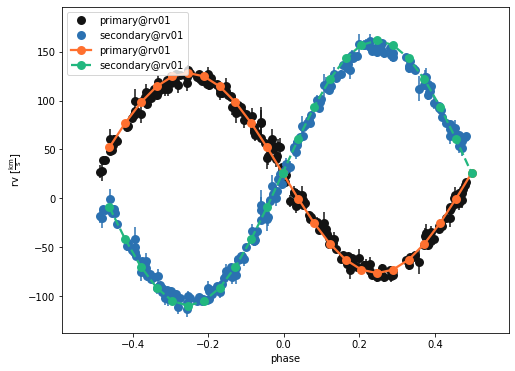

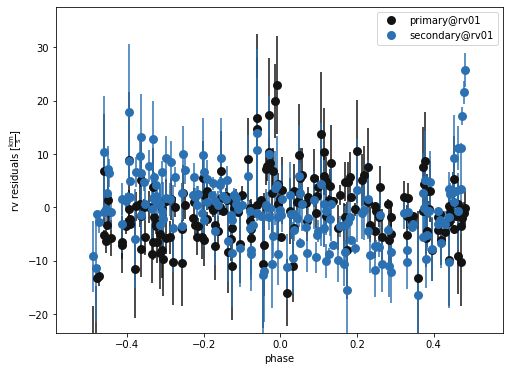

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [15]:
#compute model and check fit
b.run_compute('nm_fit', solution='nm_solution', sample_num=1)

b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='rv', x='phases', y='residuals', show=True, legend=True, marker = 'o')

In [16]:
b.adopt_solution('nm_solution')


<ParameterSet: 22 parameters | contexts: dataset, component, system>

In [17]:
#fit lc
b.disable_dataset('rv01')
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, secondary, primary>

Now we want to reduce the number of points that we need to compute. One easy way to do this is to only fit the eclipses. So let's  use our previous lc geometry solution to mask everything else. 

In [18]:
print(b.filter('lc_soln_lcgeom'))

ParameterSet: 22 parameters
R  orbit@lc_est_lcgeom@lc_soln...: binary
R  input_phases@lc_est_lcgeom@...: [-0.49964091
 -0.48263891
 -0.4768434  ...
  0.47976384
  0.48413045
  0.48728185]
R  input_fluxes@lc_est_lcgeom@...: [0.76947627 0.78081505
 0.8043889  ...
 0.86360669 0.82775647
 0.79882824]
R  input_sigmas@lc_est_lcgeom@...: [0.00328515 0.00328515
 0.00328515 ...
 0.00328515 0.00328515
 0.00328515]
R  analytic_phases@lc_est_lcge...: [-0.5   -0.495
 -0.49  ...  0.49
  0.495  0.5  ]
R  analytic_fluxes@lc_soln_lcg...: {'C': [0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683

In [19]:
adopt_parameters = ['mask_phases']
b.set_value(solution = 'lc_soln_lcgeom', qualifier='adopt_parameters', 
            value=adopt_parameters)
b.adopt_solution('lc_soln_lcgeom')

<ParameterSet: 1 parameters>

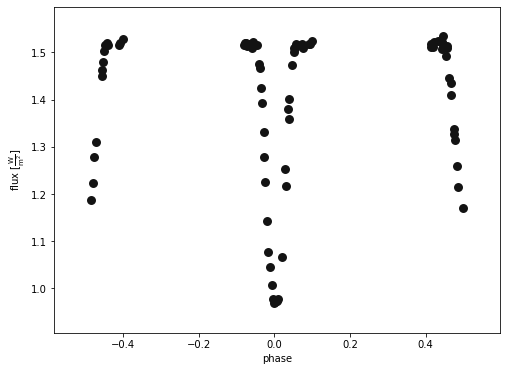

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [20]:
b.plot(kind='lc', x='phases', show='True')

In [21]:
#switch back from requivsumfrac to a primary radius
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary')


<ConstraintParameter: {requivsumfrac@binary@component} = ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component} (solar units) => 0.3451158141087794>

In [22]:
fit_params = ['teffratio@binary', 't0_supconj@binary', 'incl@binary']
b.set_value('fit_parameters', fit_params)

In [23]:
print(b.filter('nmfit'))

ParameterSet: 0 parameters
NO PARAMETERS


In [24]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [04:32<00:00, 13.62s/it]


<ParameterSet: 12 parameters | qualifiers: adopt_distributions, success, fitted_twigs, initial_values, fitted_values, fitted_units, adopt_values, fitted_uniqueids, comments, message, niter, adopt_parameters>

In [25]:
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.9160711337252425
   t0_supconj@binary@orbit@com...: 1.2335105886680555 d
      incl@binary@orbit@component: 83.27130014656936 deg


100%|██████████| 200/200 [00:04<00:00, 47.95it/s]


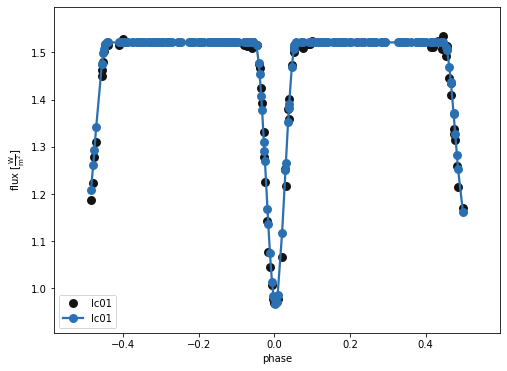

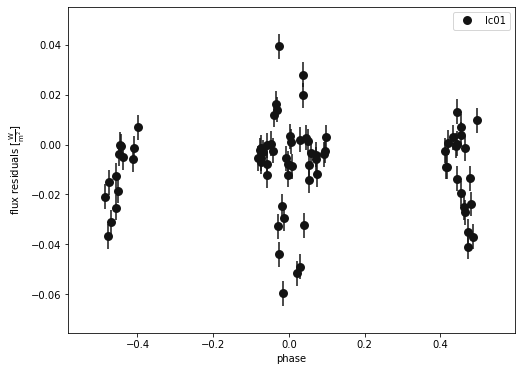

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [26]:
b.run_compute('nm_fit', solution='nm_solution', sample_num=1)

b.plot(kind='lc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')


In [27]:
b.adopt_solution('nm_solution')

<ParameterSet: 24 parameters | contexts: dataset, component>

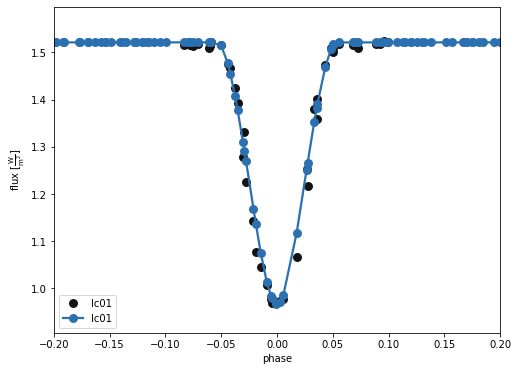

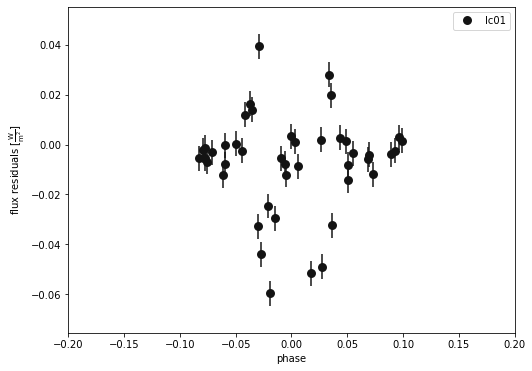

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [28]:
#look more closely at the primary eclipse
b.plot(kind='lc', x='phases', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

Exercise: Combine both light and rv curves to achieve a better fit, primarily within the eclipse. Hint: It's often better to fit a small number of parameters first. 

In [29]:
#add rv back 
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, secondary, primary>

In [30]:

fit_params = ['t0_supconj@binary', 'teffratio@binary', 'asini@binary', 'incl@binary']
b.set_value('fit_parameters', fit_params)

In [31]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [05:19<00:00, 15.99s/it]


<ParameterSet: 12 parameters | qualifiers: adopt_distributions, success, fitted_twigs, initial_values, fitted_values, fitted_units, adopt_values, fitted_uniqueids, comments, message, niter, adopt_parameters>

In [32]:
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 4 parameters
   t0_supconj@binary@orbit@com...: 1.232595109297582 d
   teffratio@binary@orbit@comp...: 0.9387696344452661
     asini@binary@orbit@component: 7.549611063758211 solRad
      incl@binary@orbit@component: 83.59289981559021 deg


In [33]:


b.run_compute('nm_fit', sample_from='nm_solution', sample_num=1)

100%|██████████| 225/225 [00:04<00:00, 54.64it/s]


<ParameterSet: 13 parameters | kinds: rv, lc>

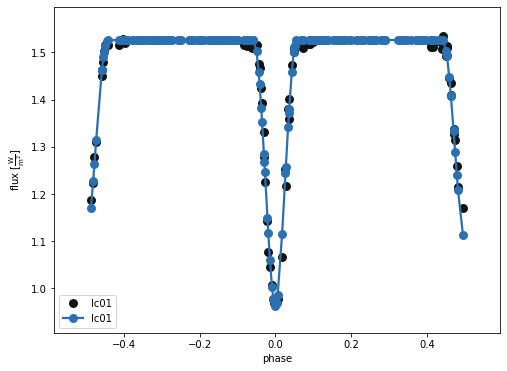

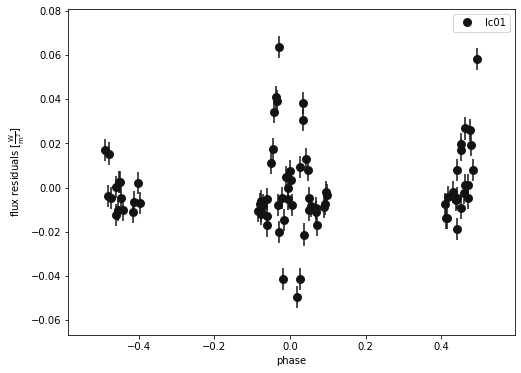

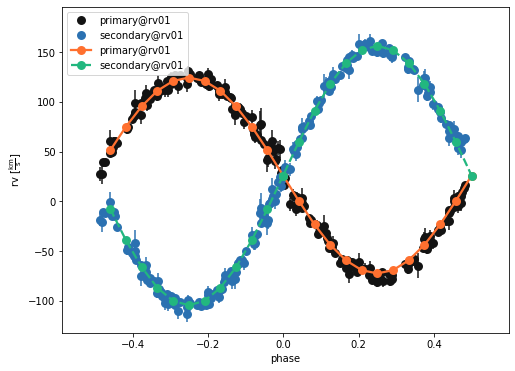

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [34]:

b.plot(kind='lc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')
b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')

In [35]:
b.adopt_solution('nm_solution')

<ParameterSet: 25 parameters | contexts: dataset, component>

In [36]:
#Different set of parameters
fit_params = ['teffratio@binary', 'requiv@primary', 'requivratio@binary']
b.set_value('fit_parameters', fit_params)

In [37]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [04:13<00:00, 12.69s/it]


<ParameterSet: 12 parameters | qualifiers: adopt_distributions, success, fitted_twigs, initial_values, fitted_values, fitted_units, adopt_values, fitted_uniqueids, comments, message, niter, adopt_parameters>

In [38]:
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.9274807446005815
    requiv@primary@star@component: 1.334273367718833 solRad
   requivratio@binary@orbit@co...: 0.9912393075862436


In [39]:
#%%timeit -r 1 -n 1

b.run_compute('nm_fit', sample_from='nm_solution', sample_num=1)

100%|██████████| 225/225 [00:04<00:00, 55.48it/s]


<ParameterSet: 13 parameters | kinds: rv, lc>

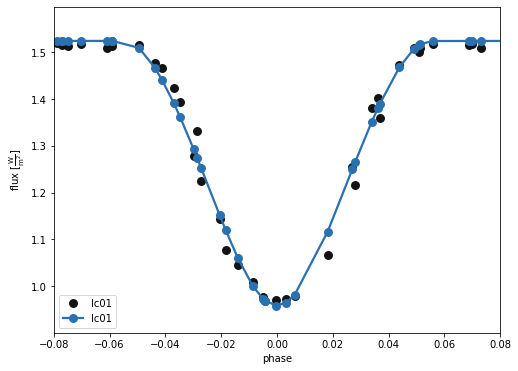

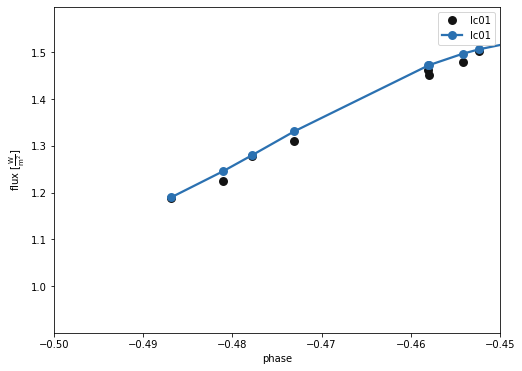

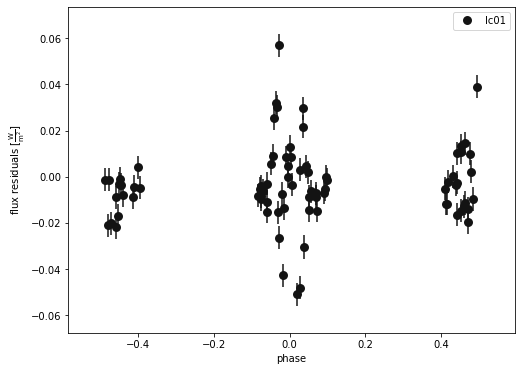

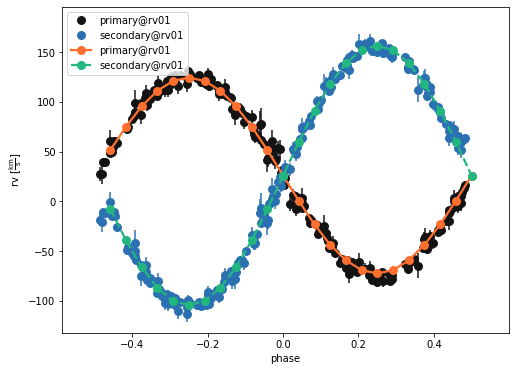

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [40]:

b.plot(kind='lc', x='phases', xlim=[-0.08,0.08], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', xlim=[-0.5,-0.45], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', y='residuals', show=True, legend=True, marker = 'o')
b.plot(kind='rv', x='phases', show=True, legend=True, marker = 'o')

In [41]:
b.adopt_solution('nm_solution')

<ParameterSet: 8 parameters | kinds: orbit, star>

In [42]:
b.save('synthetic/after_optimizers.bundle')

'synthetic/after_optimizers.bundle'